## Import Libraries

In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt

In [59]:
data = pd.read_csv('./Data/data.csv', sep=',')
y = data['churn']  # Binary target (0/1)
X = data.drop(['churn', 'customer_id'], axis=1) 

In [60]:
# Identify numerical and categorical columns
num_columns = X.select_dtypes(include='number').columns.tolist()
cat_columns = X.select_dtypes(include='object').columns.tolist()
print("Numerical features:", num_columns)
print("Categorical features:", cat_columns)



Numerical features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
Categorical features: ['country', 'gender']


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (8000, 10)
X_test shape: (2000, 10)


In [63]:
preprocess = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_columns)
)
X_train = preprocess.fit_transform(X_train)  # Shape: (n_train, m_features)
X_test = preprocess.transform(X_test)

In [64]:
X_train = np.c_[np.ones(X_train.shape[0]), X_train]  # Shape: (n_train, m_features+1)
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [65]:
print("X_train shape after preprocessing:", X_train.shape)
print("X_test shape after preprocessing:", X_test.shape)

X_train shape after preprocessing: (8000, 14)
X_test shape after preprocessing: (2000, 14)


## Define Function

In [66]:
def compute_hypothesis(X, params):
    z = np.dot(X, params)
    z = np.clip(z, -500, 500) # avoid ovrflow
    return 1/ (1 + np.exp(-z))

## Predict classes

In [67]:
def predict_classes(predictions):
    return (predictions >= 0.5).astype(int)

## Accuracy

In [68]:
def calculate_accuracy(predictions, actual):
    return np.mean(predictions == actual) * 100

 ## Cost Funtion & Ridge

In [69]:
def compute_cost(X,y, params, lambda_reg = 0):
    m = len(y)
    predictions = compute_hypothesis(X, params)
    log_loss = -np.mean(y * np.log(predictions +1e-15) + (1 -y) * (np.log(1 - predictions +1e-15)))
    reg_term = lambda_reg * np.sum(params[1:]**2)#l2
    return log_loss + reg_term

## Gradient Descend

In [70]:
def gradient_descent(X, y, learning_rate=0.05, iterations=5000, lambda_reg=0):
    m, n = X.shape
    params = np.zeros(n)  # Initialize parameters
    costs = []
    train_accuracies = []
    for i in range(iterations):
        predictions = compute_hypothesis(X, params)
        train_accuracies.append(calculate_accuracy(predict_classes(predictions), y))
        costs.append(compute_cost(X, y, params, lambda_reg))
        errors = predictions - y
        gradient = np.dot(X.T, errors) / m
        reg_gradient = np.concatenate(([0], 2 * lambda_reg * params[1:]))  # L2 gradient
        params -= learning_rate * (gradient + reg_gradient / m)
    return params, costs, train_accuracies


## Train Model

In [71]:
params_baseline, costs_baseline, acc_baseline = gradient_descent(X_train, y_train, lambda_reg=0)

In [72]:
test_pred_baseline = compute_hypothesis(X_test, params_baseline)
test_acc_baseline = calculate_accuracy(predict_classes(test_pred_baseline), y_test)

In [73]:
print(f"Training Accuracy: {acc_baseline[-1]:.2f}%")
print(f"Test Accuracy: {test_acc_baseline:.2f}%")
print(f"Cost: {costs_baseline[-1]:.4f}")
print(f"Status: {'Overfitting' if acc_baseline[-1] > test_acc_baseline + 5 else 'Underfitting' if acc_baseline[-1] < 80 else 'Good fit'}")

Training Accuracy: 80.77%
Test Accuracy: 81.80%
Cost: 0.4416
Status: Good fit


In [ ]:
# Step 8: Train and optimize Ridge model
print("\nRidge Model (lambda_reg=0.0001):")
params_ridge, costs_ridge, acc_ridge = gradient_descent(X_train, y_train, lambda_reg=0.0001)

# Step 9: Test Ridge and check overfitting
test_pred_ridge = compute_hypothesis(X_test, params_ridge)
test_acc_ridge = calculate_accuracy(predict_classes(test_pred_ridge), y_test)

print(f"Training Accuracy: {acc_ridge[-1]:.2f}%")
print(f"Test Accuracy: {test_acc_ridge:.2f}%")
print(f"Cost: {costs_ridge[-1]:.4f}")
print(f"Status: {'Overfitting' if acc_ridge[-1] > test_acc_ridge + 5 else 'Underfitting' if acc_ridge[-1] < 80 else 'Good fit'}")



Ridge Model (lambda_reg=0.0001):
Training Accuracy: 80.77%
Test Accuracy: 81.80%
Cost: 1.4103
Status: Good fit


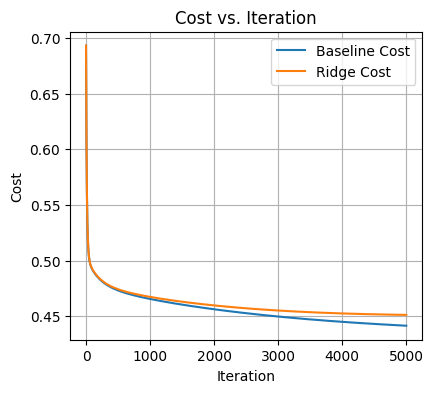

In [75]:
# Step 10: Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(costs_baseline, label='Baseline Cost')
plt.plot(costs_ridge, label='Ridge Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration')
plt.legend()
plt.grid(True)



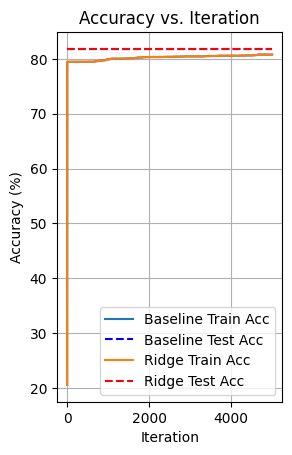

In [76]:
plt.subplot(1, 2, 2)
plt.plot(acc_baseline, label='Baseline Train Acc')
plt.plot([0, len(acc_ridge)-1], [test_acc_baseline, test_acc_baseline], 'b--', label='Baseline Test Acc')
plt.plot(acc_ridge, label='Ridge Train Acc')
plt.plot([0, len(acc_ridge)-1], [test_acc_ridge, test_acc_ridge], 'r--', label='Ridge Test Acc')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Iteration')
plt.legend()
plt.grid(True)




In [84]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt

# Step 1: Load data
data = pd.read_csv('./Data/data.csv', sep=',')
y = data['churn']  # Binary target (0/1)
X = data.drop(['churn'], axis=1)  # Features

# Check class imbalance
print("Class distribution:\n", y.value_counts(normalize=True))

# Identify numerical and categorical columns
num_columns = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
cat_columns = ['country', 'gender']
print("Numerical features:", num_columns)
print("Categorical features:", cat_columns)

# Step 2: Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Preprocess - Scale numerical, encode categorical
preprocess = make_column_transformer(
    (StandardScaler(), num_columns),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_columns)
)
X_train = preprocess.fit_transform(X_train)  # Shape: (8000, 13)
X_test = preprocess.transform(X_test)       # Shape: (2000, 13)

# Add intercept column
X_train = np.c_[np.ones(X_train.shape[0]), X_train]  # Shape: (8000, 14)
X_test = np.c_[np.ones(X_test.shape[0]), X_test]    # Shape: (2000, 14)

print("X_train shape after preprocessing:", X_train.shape)
print("X_test shape after preprocessing:", X_test.shape)

# Step 4: Define model functions
def compute_hypothesis(X, params):
    z = np.dot(X, params)
    z = np.clip(z, -500, 500)  # Avoid overflow
    return 1 / (1 + np.exp(-z))

def predict_classes(predictions):
    return (predictions >= 0.5).astype(int)

def calculate_accuracy(predictions, actual):
    return np.mean(predictions == actual) * 100  # Your accuracy function

def compute_cost(X, y, params, lambda_reg=0, weight=2):
    m = len(y)
    predictions = compute_hypothesis(X, params)
    log_loss = -np.mean(y * np.log(predictions + 1e-15) * weight + (1 - y) * np.log(1 - predictions + 1e-15))
    reg_term = lambda_reg * np.sum(params[1:]**2)  # L2 penalty, exclude intercept
    return log_loss + reg_term

# Step 5: Optimize model with gradient descent
def gradient_descent(X, y, learning_rate=0.05, iterations=10000, lambda_reg=0):
    m, n = X.shape
    params = np.zeros(n)
    costs = []
    train_accuracies = []
    for i in range(iterations):
        predictions = compute_hypothesis(X, params)
        train_accuracies.append(calculate_accuracy(predict_classes(predictions), y))
        cost = compute_cost(X, y, params, lambda_reg)
        costs.append(cost)
        errors = predictions - y
        gradient = np.dot(X.T, errors) / m
        reg_gradient = np.concatenate(([0], 2 * lambda_reg * params[1:]))  # L2 gradient
        params -= learning_rate * (gradient + reg_gradient / m)
        # Early stopping
        if i > 100 and abs(costs[-1] - costs[-2]) < 1e-6:
            print(f"Converged after {i+1} iterations")
            break
    return params, costs, train_accuracies

# Step 6: Train and optimize baseline model (no regularization)
print("\nBaseline Model (No Regularization):")
params_baseline, costs_baseline, acc_baseline = gradient_descent(X_train, y_train)

# Step 7: Test baseline and check overfitting
test_pred_baseline = compute_hypothesis(X_test, params_baseline)
test_classes_baseline = predict_classes(test_pred_baseline)
test_acc_baseline = calculate_accuracy(test_classes_baseline, y_test)
cm_baseline = confusion_matrix(y_test, test_classes_baseline)
precision_baseline = precision_score(y_test, test_classes_baseline, zero_division=0)
recall_baseline = recall_score(y_test, test_classes_baseline, zero_division=0)

print(f"Training Accuracy: {acc_baseline[-1]:.2f}%")
print(f"Test Accuracy: {test_acc_baseline:.2f}%")
print(f"Cost: {costs_baseline[-1]:.4f}")
print(f"Status: {'Overfitting' if acc_baseline[-1] > test_acc_baseline + 5 else 'Underfitting' if acc_baseline[-1] < 80 else 'Good fit'}")
print("Confusion Matrix (Baseline):\n", cm_baseline)
print(f"Precision (Baseline): {precision_baseline:.4f}")
print(f"Recall (Baseline): {recall_baseline:.4f}")

# Step 8: Train and optimize Ridge models
lambda_values = [1e-06, 0.0001]
ridge_results = []

for lambda_reg in lambda_values:
    print(f"\nRidge Model (lambda_reg={lambda_reg}):")
    params_ridge, costs_ridge, acc_ridge = gradient_descent(X_train, y_train, lambda_reg=lambda_reg)
    test_pred_ridge = compute_hypothesis(X_test, params_ridge)
    test_classes_ridge = predict_classes(test_pred_ridge)
    test_acc_ridge = calculate_accuracy(test_classes_ridge, y_test)
    cm_ridge = confusion_matrix(y_test, test_classes_ridge)
    precision_ridge = precision_score(y_test, test_classes_ridge, zero_division=0)
    recall_ridge = recall_score(y_test, test_classes_ridge, zero_division=0)
    
    print(f"Training Accuracy: {acc_ridge[-1]:.2f}%")
    print(f"Test Accuracy: {test_acc_ridge:.2f}%")
    print(f"Cost: {costs_ridge[-1]:.4f}")
    print(f"Status: {'Overfitting' if acc_ridge[-1] > test_acc_ridge + 5 else 'Underfitting' if acc_ridge[-1] < 80 else 'Good fit'}")
    print("Confusion Matrix (Ridge):\n", cm_ridge)
    print(f"Precision (Ridge): {precision_ridge:.4f}")
    print(f"Recall (Ridge): {recall_ridge:.4f}")
    
    ridge_results.append({
        'lambda_reg': lambda_reg,
        'params': params_ridge,
        'costs': costs_ridge,
        'train_acc': acc_ridge,
        'test_acc': test_acc_ridge
    })

# Step 9: Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(costs_baseline, label='Baseline Cost')
for result in ridge_results:
    plt.plot(result['costs'], label=f'Ridge Cost (λ={result["lambda_reg"]})')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs. Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(acc_baseline, label='Baseline Train Acc')
plt.plot([0, len(acc_baseline)-1], [test_acc_baseline, test_acc_baseline], 'b--', label='Baseline Test Acc')
for result in ridge_results:
    plt.plot(result['train_acc'], label=f'Ridge Train Acc (λ={result["lambda_reg"]})')
    plt.plot([0, len(result['train_acc'])-1], [result['test_acc'], result['test_acc']], '--', label=f'Ridge Test Acc (λ={result["lambda_reg"]})')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.close()

Class distribution:
 churn
0    0.7963
1    0.2037
Name: proportion, dtype: float64
Numerical features: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
Categorical features: ['country', 'gender']
X_train shape after preprocessing: (8000, 14)
X_test shape after preprocessing: (2000, 14)

Baseline Model (No Regularization):
Converged after 412 iterations
Training Accuracy: 80.96%
Test Accuracy: 81.05%
Cost: 0.6980
Status: Good fit
Confusion Matrix (Baseline):
 [[1556   51]
 [ 328   65]]
Precision (Baseline): 0.5603
Recall (Baseline): 0.1654

Ridge Model (lambda_reg=1e-06):
Converged after 412 iterations
Training Accuracy: 80.96%
Test Accuracy: 81.05%
Cost: 0.6980
Status: Good fit
Confusion Matrix (Ridge):
 [[1556   51]
 [ 328   65]]
Precision (Ridge): 0.5603
Recall (Ridge): 0.1654

Ridge Model (lambda_reg=0.0001):
Converged after 408 iterations
Training Accuracy: 80.96%
Test Accuracy: 81.05%
Cost: 0.6981
Status: Good fit